In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd
import pickle
import sys

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gaussian Mixture Regression and LQR
This is an example of learning a GMM over some trajectories demonstrations, reproducing it with GMR and tracking the reproduction using LQR.



## Loading Gaussian Mixture Model (GMM)

In [5]:
# Required for rel import
new_path = "/home/agro-legion/reactive_ws/src/reactive-tp-gmr/lfd_executor/lfd_executor"

if new_path not in sys.path:
    sys.path.append(new_path)
from pbdlib_custom import gmmr

# Fix the change in structure between pickle and ROS2 structure
sys.modules['gmmr'] = gmmr


In [6]:
### Import best model (40 demonstrations)
model_name = "/media/data/OneDrive/MSc thesis/05 Experiments/apple_harvesting/models/approach/gmr/demos_40.pickle"

# Load model from file location
model = pickle.load(open(model_name, "rb"), encoding='latin1')

In [7]:
### Load demonstrations not used in training
dp_1 = "/media/data/OneDrive/MSc thesis/05 Experiments/apple_harvesting/demonstrations_apple_harvesting/good/approaching"
filelist = next(os.walk(dp_1))[2]
data_1 = []
for f in filelist:
    if f.endswith("_slash_relaxed_ik_slash_ee_pose_goals.csv"):
        temp = np.genfromtxt(dp_1 + '/' + f, delimiter=',')
        data_1.append(temp[1:, (9, 10, 11, 17, 18, 19)])

In [8]:
# Select last ten demo's as example
data = data_1[90:]

In [9]:
# Fix for start and end frame
data_start = []
data_end = []
def transform_matrix_3D(a):
    # Translation
    dX = - equal[0]
    dY = - equal[1]
    dZ = - equal[2]

    # Rotation
    rC = np.cos(equal[3])
    rS = np.sin(equal[3])
    pC = np.cos(equal[4])
    pS = np.sin(equal[4])
    yC = np.cos(equal[5])
    yS = np.sin(equal[5])

    #Matrices and dot product
    Translate_matrix = np.array([[1, 0, 0, dX],
                               [0, 1, 0, dY],
                               [0, 0, 1, dZ],
                               [0, 0, 0, 1]])
    Rotate_X_matrix = np.array([[1, 0, 0, 0],
                              [0, rC, -rS, 0],
                              [0, rS, rC, 0],
                              [0, 0, 0, 1]])
    Rotate_Y_matrix = np.array([[pC, 0, pS, 0],
                              [0, 1, 0, 0],
                              [-pS, 0, pC, 0],
                              [0, 0, 0, 1]])
    Rotate_Z_matrix = np.array([[yC, -yS, 0, 0],
                              [yS, yC, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
    rot_3d_matrix = np.dot(Rotate_Z_matrix,np.dot(Rotate_Y_matrix,np.dot(Rotate_X_matrix,Translate_matrix)))

    # Apply translation and rotation
    pos = [a[0], a[1], a[2], 1]
    pos_trans = np.dot(rot_3d_matrix,np.transpose(pos))[0:3]
    ori_trans = a[3:] - equal[3:]
    pose_trans = np.concatenate((pos_trans, ori_trans), axis=None)

    return pose_trans

for p in data:
    # Set start point
    equal = p[0,:]
    arr_trans = np.apply_along_axis(transform_matrix_3D, 1, p)
    data_start.append(arr_trans)

for p in data:
    # Set start point
    equal = p[-1,:]
    arr_trans = np.apply_along_axis(transform_matrix_3D, 1, p)
    data_end.append(arr_trans)

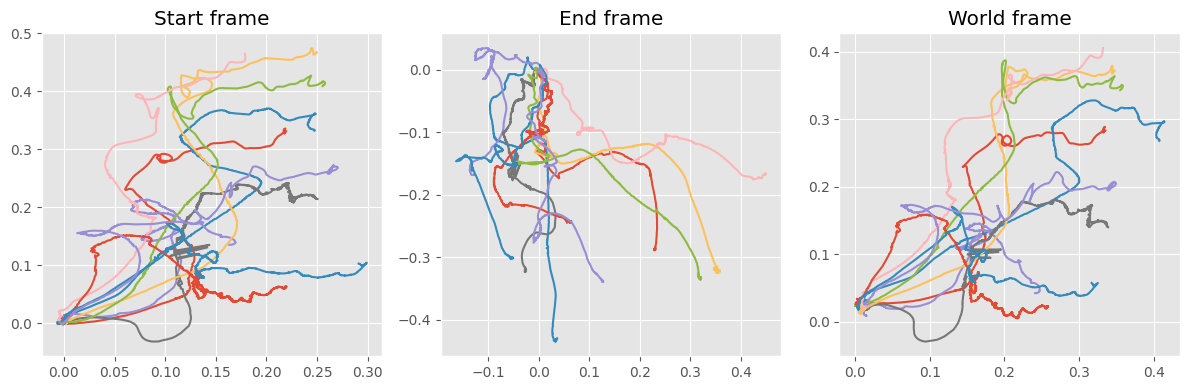

In [10]:
# Plot 10 examples
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,4)
# Set corresponding axis for plot
x = 0
y = 1

ax[0].set_title('Start frame')
for p in data_start:
    ax[0].plot(p[:, x], p[:, y])
    
ax[1].set_title('End frame')
for p in data_end:
    ax[1].plot(p[:, x], p[:, y])
    
ax[2].set_title('World frame')
for p in data:
    ax[2].plot(p[:, x], p[:, y])
plt.tight_layout()

In [11]:
# Add time axis to data
demo_times = []
for d in data:
    demo_times += [np.linspace(0, 100, d.shape[0])]

### Gaussian Mixture Regression
Get the state for each timestep

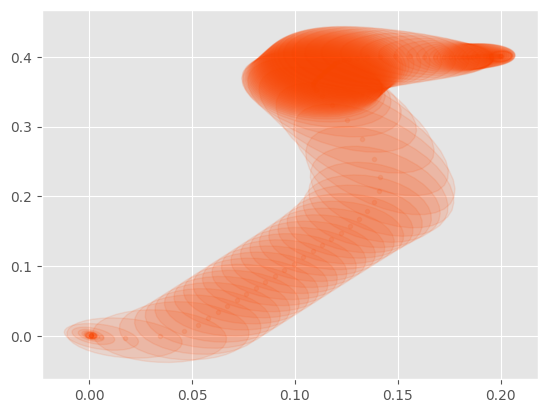

In [12]:
# Create arrays for transforming data
A0 = np.identity(n=7)
An = np.identity(n=7)
b0 = np.zeros(7)
bn = np.zeros(7)
A0[1:7, 1:7], b0[1:7] = pbd.utils.inv_for_lintrans([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
An[1:7, 1:7], bn[1:7] = pbd.utils.inv_for_lintrans([0.2, 0.4, -0.2, 0.0, 0.0, 1.57])

# Select columns for split models
dim1 = np.array([0, 1, 2, 3, 4,  5,  6])
dim2 = np.array([0, 7, 8, 9, 10, 11, 12])

# Split models
_mod1 = model.gmm_.marginal_array(dim1).lintrans(A0, b0)
_mod2 = model.gmm_.marginal_array(dim2).lintrans(An, bn)

# Combine models
_prod = _mod1 * _mod2

# Get the most probable trajectory for this initial and final pose
mu, sigma = _prod.condition(model.t[:, None], dim_in=slice(0, 1), dim_out=slice(0, 7))

pbd.plot_gmm(mu, sigma, dim=[1, 2], color='orangered', alpha=0.1)


Text(0.5, 0, 'timestep')

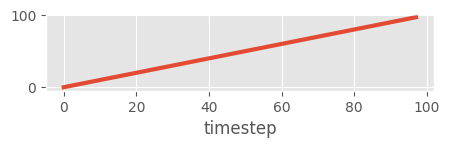

In [13]:
sq = [i for i in range(0,len(mu))]

plt.figure(figsize=(5, 1))
# plt.axis('off')
plt.plot(sq, lw=3)
plt.xlabel('timestep')

## Create and solve LQR 

In [14]:
sigma[:,1:,1:].shape

(98, 6, 6)

In [91]:
A, b = pbd.utils.get_canonical(6, 1, 0.025)

In [92]:
lqr = pbd.LQR(A, b, horizon=len(mu))
lqr.gmm_xi = [mu[:,1:], sigma[:,1:,1:], sq]
lqr.gmm_u = 3.

In [93]:
lqr.ricatti()

In [94]:
xi, _ = lqr.get_seq(data[4][0])

## Plotting reproduced trajectory (position and against time)

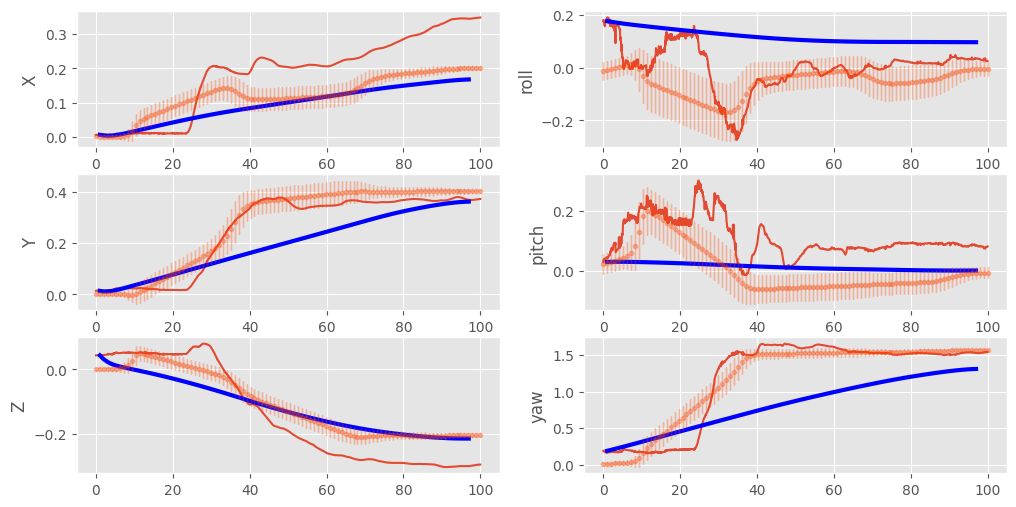

In [95]:
# plotting
fig, ax = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12,6)

headers = ["X", "Y", "Z", "roll", "pitch", "yaw"]
# position plotting

for i in range(3):
    for j in range(2):

        row = i + 3*j

        ax[i,j].plot(demo_times[4], data[4][:, row])
        ax[i,j].set_ylabel(headers[row])

        ax[i,j].plot(sq[1:], xi[:, row], 'b', lw=3)
        # ax[i].plot(sq[:-1], lqr.ds[:, i], 'gold', lw=3)
        pbd.plot_gmm(mu, sigma, dim=[0, row+1], color='orangered', ax=ax[i,j], alpha=0.3)

## Add tracking to motion

In [97]:
# Load initial pose
xi0 = np.asarray([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Put in initial pose
xis = [xi0]
# Initialize first control input
us = [-lqr._K[0].dot(xi0) + lqr._Kv[0].dot(lqr._v[0])]

# List of desired states
ds = []

# List of goal states, initial goal is start pose
xi_g = [xi0]

# Noise settings
amplitude_factor = 0.2
period_factor = 40 # Time to activate noise. np.pi * 2 / 10 # Division sets number of timesteps per sinus cycle
offsets = []
# Create no offset array
arr_offset = np.zeros(6)

# Loop over time
for t in range(1, lqr.horizon-1):
    
    # Determine noise
    offsets += [0.0] # [amplitude_factor * (t > period_factor)]
    
    # Put offset in array
    arr_offset[0] = offsets[-1]

    xis += [xi_g[-1] + arr_offset]
    # Control input based on current pose
    us += [-lqr._K[t].dot(xis[-1]) + lqr._Kv[t].dot(lqr._v[t+1])]

    # Goal pose, based on current pose and control input based on current pose
    xi_g += [lqr.A.dot(xis[-1]) + lqr.B.dot(us[-1])]

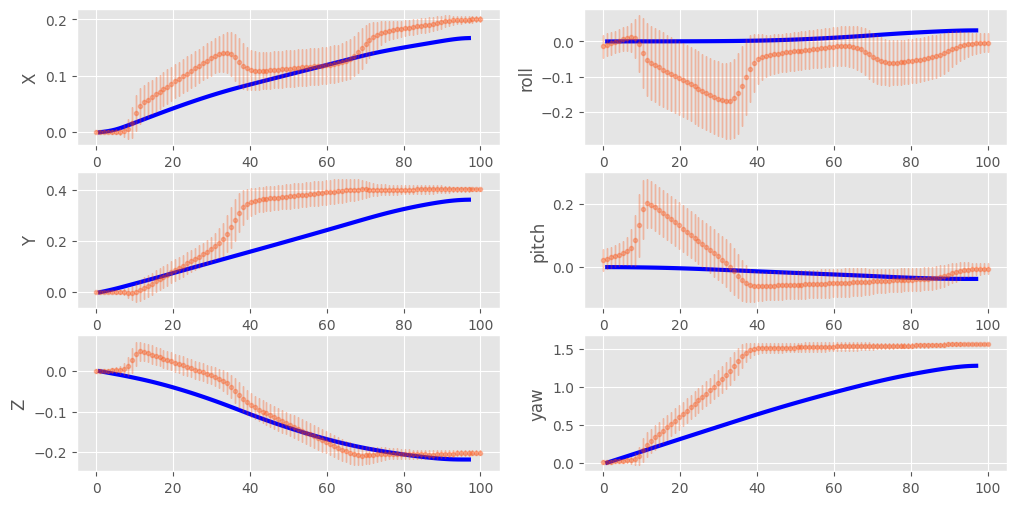

In [98]:
# plotting
fig, ax = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12,6)

headers = ["X", "Y", "Z", "roll", "pitch", "yaw"]
# position plotting

for i in range(3):
    for j in range(2):

        row = i + 3*j

        #ax[i,j].plot(demo_times[4], data[4][:, row])
        ax[i,j].set_ylabel(headers[row])

        ax[i,j].plot(sq[1:], np.asarray(xi_g)[:, row], 'b', lw=3)
        pbd.plot_gmm(mu, sigma, dim=[0, row+1], color='orangered', ax=ax[i,j], alpha=0.3)


### Initialize infinite LQR

In [99]:
A, b = pbd.utils.get_canonical(6, 1, 0.025)

In [112]:
from scipy.linalg import solve_discrete_are as solve_algebraic_riccati_discrete
# Load initial pose
xi0 = np.asarray([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Put in initial pose
xis = [xi0]
# Initialize first control input
us = [-lqr._K[0].dot(xi0) + lqr._Kv[0].dot(lqr._v[0])]

# List of desired states
ds = []

# List of goal states, initial goal is start pose
xi_g = [xi0]

# Noise settings
amplitude_factor = 0.2
period_factor = 40 # Time to activate noise. np.pi * 2 / 10 # Division sets number of timesteps per sinus cycle
offsets = []
# Create no offset array
arr_offset = np.zeros(6)

lqr.gmm_u = -3.0

# Loop over time
for t in range(1, lqr.horizon-1):
    # Calculate GMR at each timestep and update LQR
    # Create arrays for transforming data
    A0 = np.identity(n=7)
    An = np.identity(n=7)
    b0 = np.zeros(7)
    bn = np.zeros(7)
    A0[1:7, 1:7], b0[1:7] = pbd.utils.inv_for_lintrans([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    An[1:7, 1:7], bn[1:7] = pbd.utils.inv_for_lintrans([0.2, 0.4, -0.2, 0.0, 0.0, 1.57])

    # Select columns for split models
    dim1 = np.array([0, 1, 2, 3, 4,  5,  6])
    dim2 = np.array([0, 7, 8, 9, 10, 11, 12])

    # Split models
    _mod1 = model.gmm_.marginal_array(dim1).lintrans(A0, b0)
    _mod2 = model.gmm_.marginal_array(dim2).lintrans(An, bn)

    # Combine models
    _prod = _mod1 * _mod2

    # Get the most probable trajectory for this initial and final pose
    mu, sigma = _prod.condition(model.t[:, None], dim_in=slice(0, 1), dim_out=slice(0, 7))

    # Put in LQR
    lqr.gmm_xi = [mu[:,1:], sigma[:,1:,1:], sq]

    # Infinite horizon LQR stuff
    R = lqr.get_R(t) # Control cost matrix

    # Covariance of this state
    Q = lqr.gmm_xi[1][t]

    P = solve_algebraic_riccati_discrete(lqr.A,lqr.B,Q,R)

    L = np.linalg.inv(lqr.B.T @ P @ lqr.B + R) @ lqr.B.T @ P @ lqr.A # Feedback gain (discrete version)

    # Determine noise
    offsets += [0.0] # [amplitude_factor * (t > period_factor)]
    
    # Put offset in array
    arr_offset[0] = offsets[-1]

    xis += [xi_g[-1] + arr_offset]
    # Control input based on current pose
    us += [L @ (lqr.gmm_xi[0][t] - xis[-1])]  # [-lqr._K[t].dot(xis[-1]) + lqr._Kv[t].dot(lqr._v[t+1])]

    # Goal pose, based on current pose and control input based on current pose
    xi_g += [lqr.A.dot(xis[-1]) + lqr.B.dot(us[-1])]

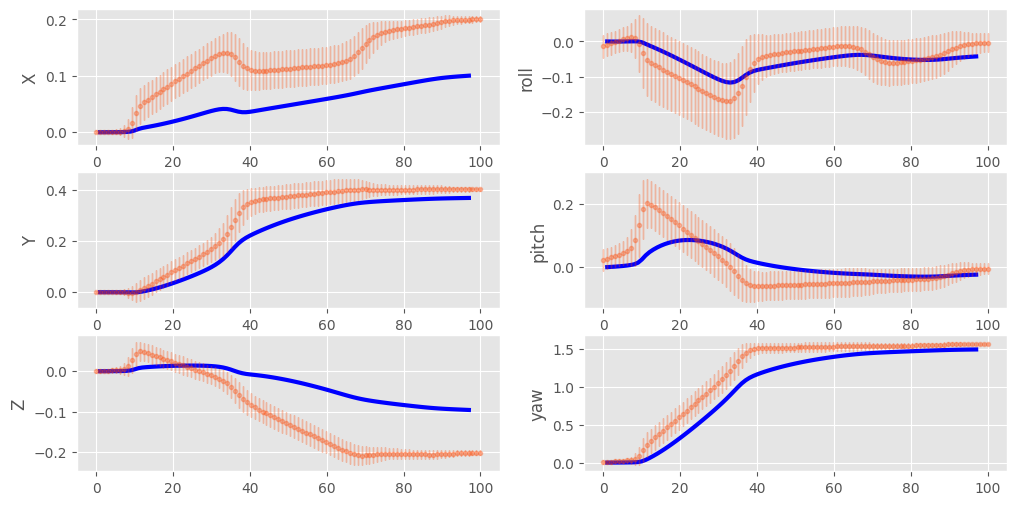

In [113]:
# plotting
fig, ax = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(12,6)

headers = ["X", "Y", "Z", "roll", "pitch", "yaw"]
# position plotting

for i in range(3):
    for j in range(2):

        row = i + 3*j

        #ax[i,j].plot(demo_times[4], data[4][:, row])
        ax[i,j].set_ylabel(headers[row])

        ax[i,j].plot(sq[1:], np.asarray(xi_g)[:, row], 'b', lw=3)
        pbd.plot_gmm(mu, sigma, dim=[0, row+1], color='orangered', ax=ax[i,j], alpha=0.3)